In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from ast import literal_eval

In [2]:
FOLDER_PATH = 'data/'
DATA_COLUMNS = ['wiki_movie_id', 'freebase_movie_id', 'movie_name',
       'movie_box_office_revenue', 'movie_runtime', 'languages', 'countries',
       'genres', 'imdb_id', 'cast', 'rating', 'votes', 'budget', 'plot',
       'characters_names', 'main_character', 'release_year']
df = pd.read_csv(FOLDER_PATH + 'movie_processed.csv', names=DATA_COLUMNS, header=0, index_col=0)

In [3]:
df.head()

,wiki_movie_id,freebase_movie_id,movie_name,movie_box_office_revenue,movie_runtime,languages,countries,genres,imdb_id,cast,rating,votes,budget,plot,characters_names,main_character,release_year
0,975900,/m/03vyhn,Ghosts of Mars,14010832.0,98.0,['English'],['United States of America'],"['Thriller', 'Science Fiction', 'Horror', 'Adv...",228333.0,"['Natasha Henstridge', 'Ice Cube', 'Jason Stat...",4.9,55370.0,28000000.0,"Set in the second half of the 22nd century, th...","['Akooshay', 'Lieutenant Melanie Ballard', 'De...",Lieutenant Melanie Ballard,2001.0
1,9363483,/m/0285_cd,White Of The Eye,NaN,110.0,['English'],['United Kingdom'],"['Thriller', 'Erotic thriller', 'Psychological...",NaN,NaN,NaN,NaN,NaN,A series of murders of rich young women throug...,[],NaN,1987.0
2,261236,/m/01mrr1,A Woman in Flames,NaN,106.0,['German'],['Germany'],['Drama'],83949.0,"['Gudrun Landgrebe', 'Mathieu Carrière', 'Hann...",6.0,591.0,NaN,"Eva, an upper class housewife, becomes frustra...",[],NaN,1983.0
3,18998739,/m/04jcqvw,The Sorcerer's Apprentice,NaN,86.0,['English'],['South Africa'],"['Family Film', 'Fantasy', 'Adventure', 'World...",NaN,NaN,NaN,NaN,NaN,"Every hundred years, the evil Morgana returns...",['Morgana'],Morgana,2002.0
4,6631279,/m/0gffwj,Little city,NaN,93.0,['English'],['United States of America'],"['Romantic comedy', 'Ensemble Film', 'Comedy-d...",NaN,NaN,NaN,NaN,NaN,"Adam, a San Francisco-based artist who works a...","['Rebecca', 'Nina']",Nina,1997.0


### Analysis for research question n*1

In [4]:
# We remove the movies with no release date since it will be impossible to include them in the time evolution (2619 movies removed)
df_r1 = df[df["release_year"].notna()]

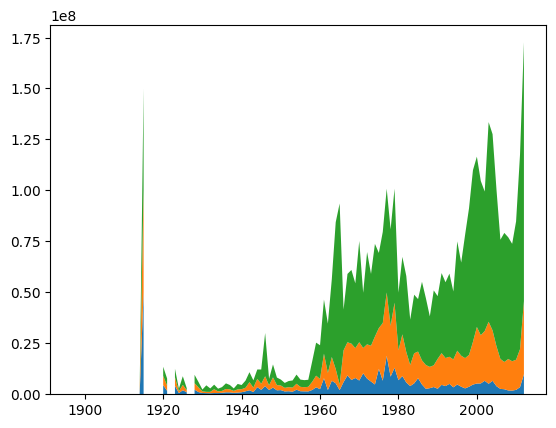

In [26]:
stats = df_r1[["release_year", "movie_box_office_revenue"]].groupby("release_year").describe()
a = stats.movie_box_office_revenue["25%"]
b = stats.movie_box_office_revenue["50%"]
c = stats.movie_box_office_revenue["75%"]
plt.stackplot(stats.index, a, b, c, labels=["25%", "50%", "75%"])
plt.show()

In [62]:
df_test = df_r1[0:3][["movie_box_office_revenue", "genres"]]
df_test[0:3]["genres"].apply(literal_eval).apply(lambda x: [i for i in x])

0    [Thriller, Science Fiction, Horror, Adventure,...
1    [Thriller, Erotic thriller, Psychological thri...
2                                              [Drama]
Name: genres, dtype: object

/var/folders/07/9l9kqd013xjdlz8_0b2__8xr0000gq/T/ipykernel_29545/552122602.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["decade"] = df["release_year"].apply(lambda x: int(x/10)*10)


<AxesSubplot: title={'center': 'movie_runtime'}, xlabel='decade'>

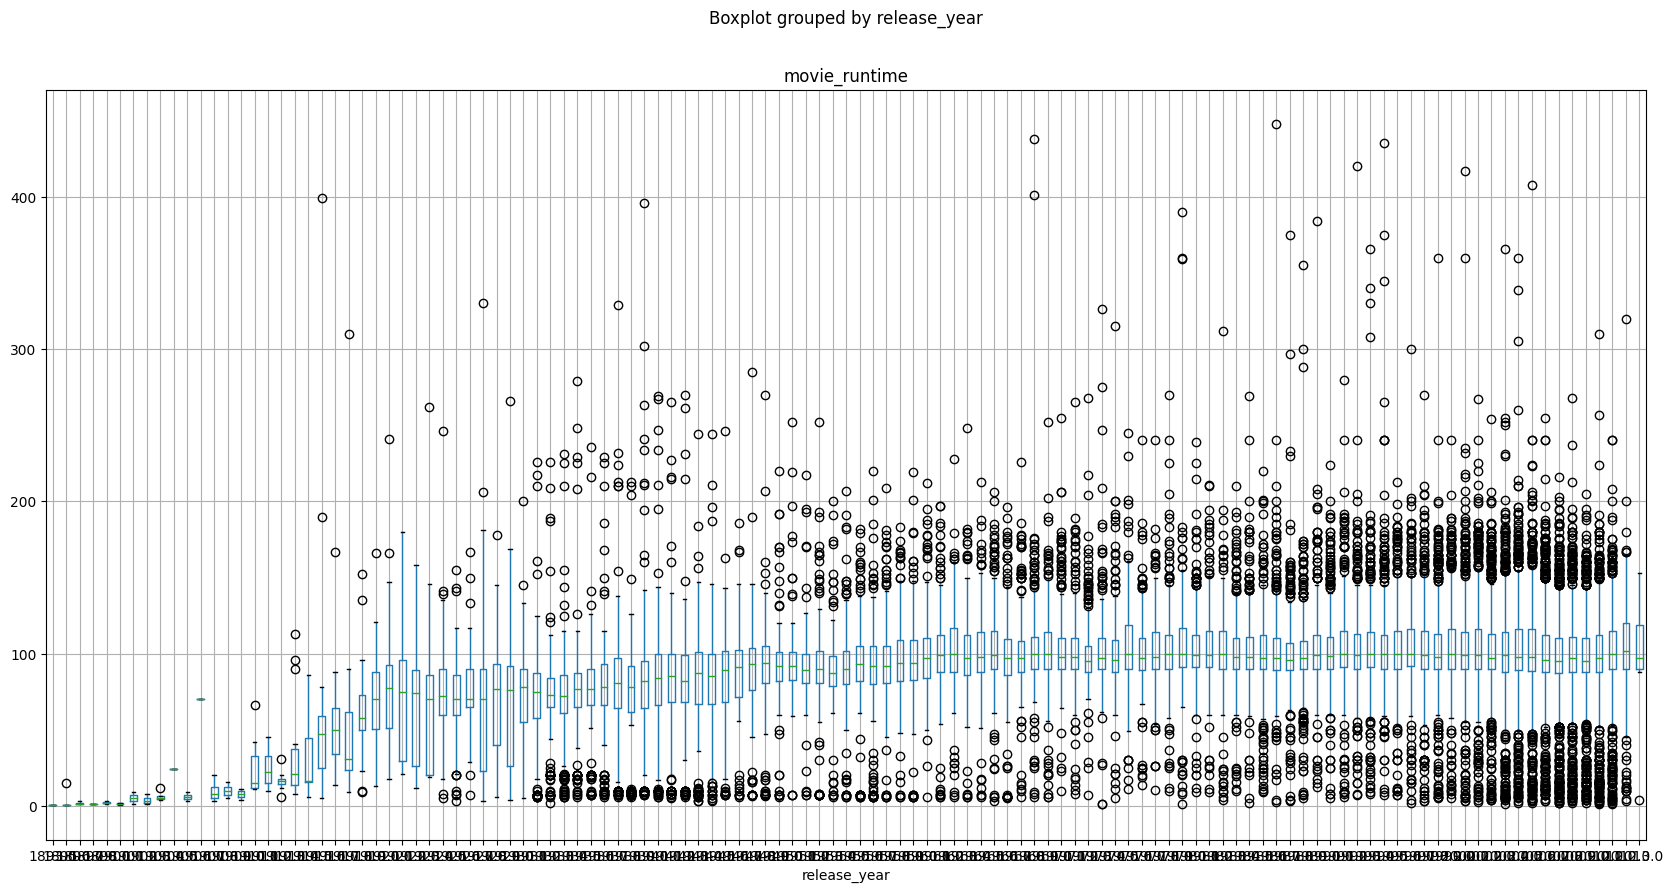

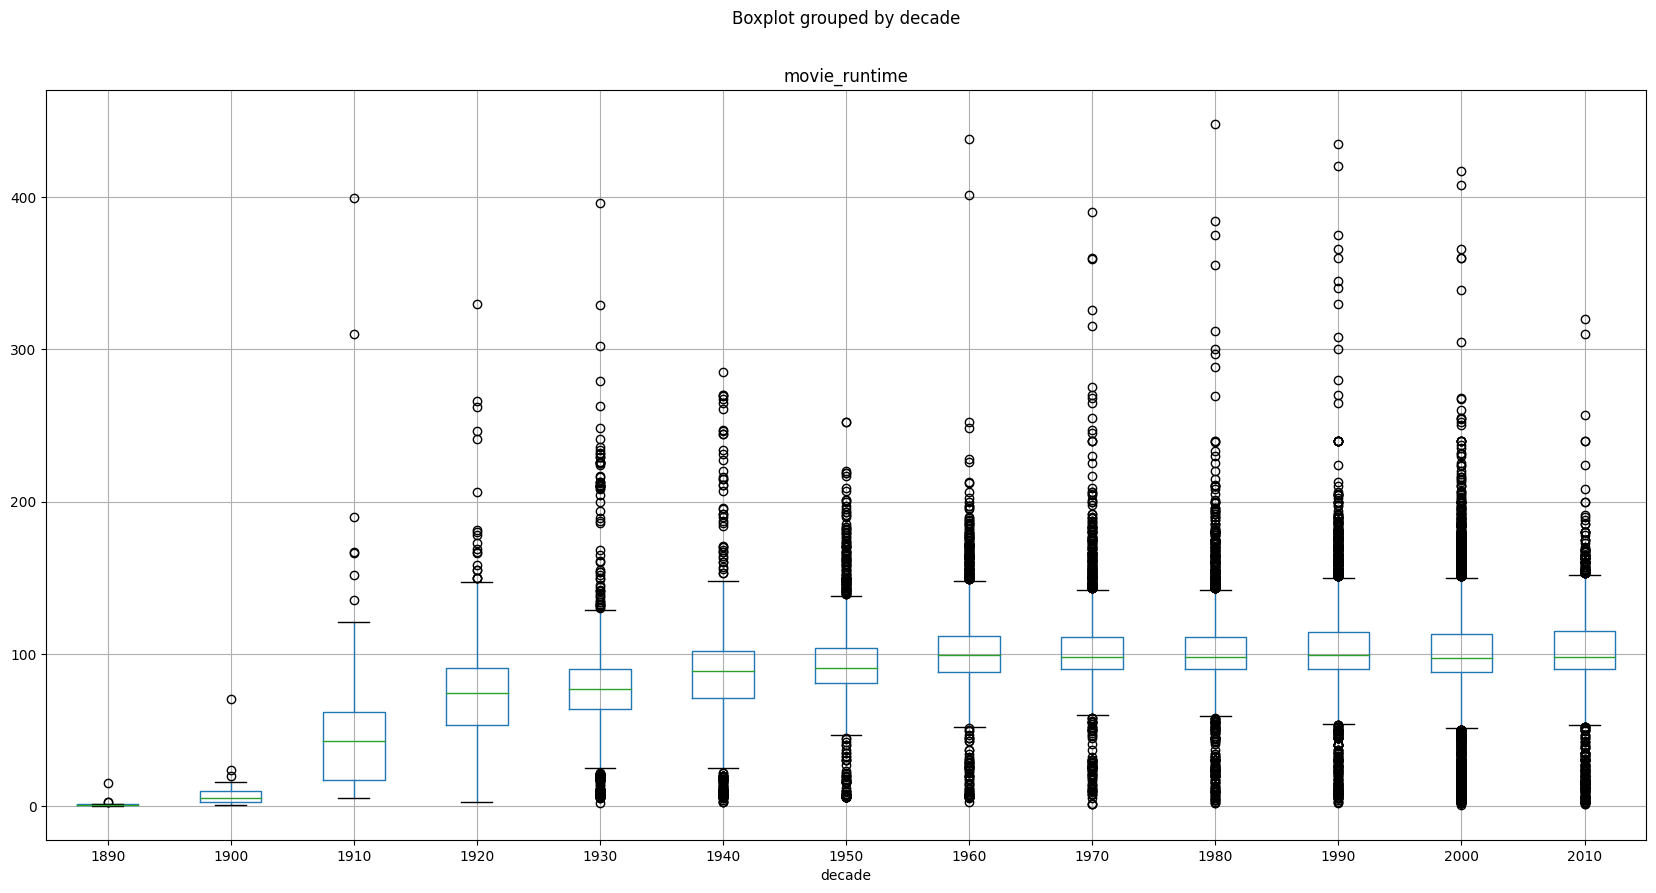

In [5]:
#### Runtime evolution
# Cleaning runtime data

# soldiers of freedom is indeed a 6h movie
# Unsung heroes is actually 98 min long
# Swallow the sun is a TV series so indeed really long...
# heimat est une serie de films...
# once a eagle is a mini serie

## TODO=> faire un stackplot à la place
df_r1.sort_values("movie_runtime", ascending=False)[["movie_name", "movie_runtime"]].head(30)

# Remove outliers
# We remove movies with a runtime higher than 6h as it corresponds mostly to TV series, mini series and errors (removed 20 movies)
df_runtime = df_r1[df_r1["movie_runtime"] < 450]
def group_by_decade(df):
    df["decade"] = df["release_year"].apply(lambda x: int(x/10)*10)
    return df

df_runtime.boxplot(column="movie_runtime", by="release_year", figsize=(20, 10))

df_runtime_decade = group_by_decade(df_runtime)
df_runtime_decade.boxplot(column="movie_runtime", by="decade", figsize=(20, 10))

In [6]:
import numpy as np

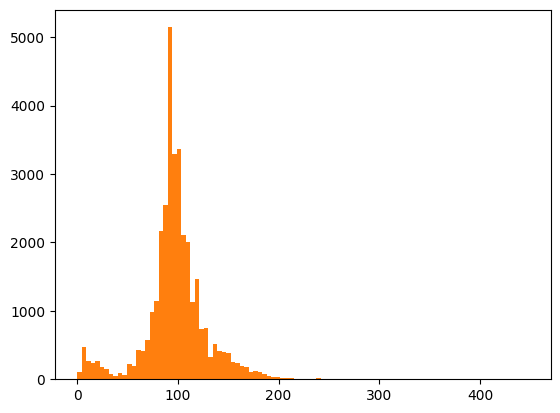

In [7]:
df_r1_clean = df_r1[df_r1["movie_runtime"] < 450].sort_values("movie_runtime", ascending=False)
movie_mean_by_year = df_r1_clean.groupby("release_year")["movie_runtime"].mean()
hist, edges = np.histogram(df_r1_clean["movie_runtime"], bins=100)
colors = np.array(["C0", "C1"])[(edges[:-1] > 0).astype(int)]
plt.bar(edges[:-1], hist, width=np.diff(edges), align="edge", color=colors)
plt.show()

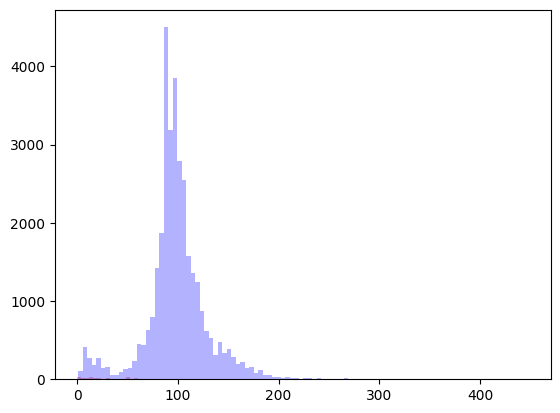

In [10]:
df_r1_clean_1 = df_r1_clean[df_r1_clean.release_year < 1920]
df_r1_clean_2 = df_r1_clean[(df_r1_clean.release_year >= 1920)]

plt.hist(df_r1_clean_1["movie_runtime"], bins=100, color="red", alpha=0.3, label="Before 1950")
plt.hist(df_r1_clean_2["movie_runtime"], bins=100, color="blue", alpha=0.3, label="After 1950")
plt.show()